In [1]:
########################libraries #############################################
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
#import seaborn as sns
import random
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import os
import seaborn as sns
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
import scipy
from random import sample
from Levenshtein import distance
from scipy.spatial.distance import pdist, squareform
import Bio
#import Bio.Align as Align
#from Bio.Align import substitution_matrices
#aligner = Align.PairwiseAligner()
#aligner.substitution_matrix = substitution_matrices.load("BLOSUM45")
%matplotlib inline
from Bio.SubsMat import MatrixInfo as matlist
import itertools
from scipy import stats
import matplotlib.ticker as plticker




/home/perr/.local/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


## create a blosum where all the values are positive 

In [2]:
matrix = matlist.blosum30 #import blosum 30 matrix
for key in matrix:
    a, b = key
    if a == b: # if it's the same AA give the value -99
        matrix[key] = -99


# how the data is distributed
hist = {}
for key in matrix:
    val = matrix[key]
    hist[val] = hist.get(val, 0) + 1

hist_series = pd.Series(hist)
hist_series = hist_series.sort_index()

# Change to all positive scale
max_val = max(hist_series.index)

new_matrix = {} # a dictionary where there is each subsitition for aa combinations
for key in matrix:
    val = matrix[key]
    a, b = key
    if a == b:
        new_matrix[key] = 0
    else:
        new_matrix[key] = max_val+1 - val # the most similar substitution will get score 1

In [3]:
def dis_blossom(seqa,seqb,score_dict):
    """
    compare and return blossom distance score between to same length sequences
    :param seqa:
    :param seqb:
    :param score_dict:a dictionary with the substitions score calaulated earlier
    :return:Blossom distance
    """
    blossom_score=0
    for i in range(len(seqa)):
        if seqa[i]==None:
            print("check for problem in {}".format(seqa))
        if seqb[i]==None:
            print("check for problem in {}".format(seqb))            
        substitution =(seqa[i],seqb[i])
        if substitution not in score_dict:
            substitution=(seqb[i],seqa[i]) #check the oposite key score(the order doesn't affect the score)
        blossom_score+=score_dict[substitution]
    return blossom_score

In [4]:
def distance_map(df, title,mode,pep_number=False,random_sampling=False,save_fig=False,xlabel=None,ylabel=None):
    """
    
                    
    :param df: given df
    :param pep_number: the number of peptide for the ramdom sampling
    :param :mode : the relevent distance function
    :return: return it's peptide accepted hamming distance map sd a df and it's hamming distance"""
    if isinstance(df, pd.DataFrame):
        if "probabilty_res_MCMC" in df.columns: #relevant only for simulation outputs
            df = df.loc[df['probabilty_res_MCMC'] == "True"].copy()
            df = df.drop_duplicates(subset="Peptide", keep='first', inplace=False)
        if "Peptide" in df.columns:
            df.set_index("Peptide",inplace=True)    
        peptide_list = df.index.tolist()
    else:
        df=peptide_list
    if random_sampling:
        peptide_list= sample(peptide_list, pep_number) #creates hamming map for sampled data in selected pep number length
    if pep_number:
        peptide_list=peptide_list[:pep_number]
    transformed_strings = np.array(peptide_list).reshape(-1,1) #transform the list into np array 
        
    if mode=="hamming" :
        distance_matrix = pdist(transformed_strings,lambda x,y: distance(x[0],y[0])) # distances vector
    elif mode=="Blossom":
        distance_matrix = pdist(transformed_strings,lambda x,y: dis_blossom(x[0],y[0],new_matrix)) # distances vector
    squared_matrix_np=squareform(distance_matrix)
    plt.figure(figsize=(50,50))
    squared_matrix_pd = pd.DataFrame(data=squared_matrix_np, index=peptide_list, columns=peptide_list)
    heatmap = sns.heatmap(squared_matrix_pd,xticklabels=True, yticklabels=True)
    heatmap.set_title('{mode} based heatmap {title}'.format(mode=mode,title=title),fontsize=30)
    heatmap.set_xlabel(xlabel)
    heatmap.set_ylabel(ylabel)
    heatmap.yaxis.label.set_size(fontsize=35)
    heatmap.xaxis.label.set_size(fontsize=35)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=50)
    sns.set(font_scale = 1.6)

    if save_fig:
        plt.gcf().savefig('{mode} based heatmap {title}'.format(mode=mode,title=title),dpi=200 ,bbox_inches='tight')
    return squared_matrix_pd


In [11]:
def distance_distribution(df,title):
    """get hamming or blosum df and return the distances distributions"""
    x=np.triu(df)
    vals=x.flatten()
    vals=list(vals)
    filtered=list(filter(lambda a: a != 0, vals))
    filtered.sort()
    plt.clf()
    ax=sns.countplot(x=filtered,color="blue",alpha=0.5)
    for rect in ax.patches:
        height = rect.get_height()
       # print(height)
        ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
    plt.gcf().savefig("Hamming histogram {}".format(title), dpi=100)


# outout example

In [12]:
df=pd.read_csv("/home/perr/Desktop/sim/project_elinor/output/1000 - strict updated feb working/18.csv",low_memory=False)

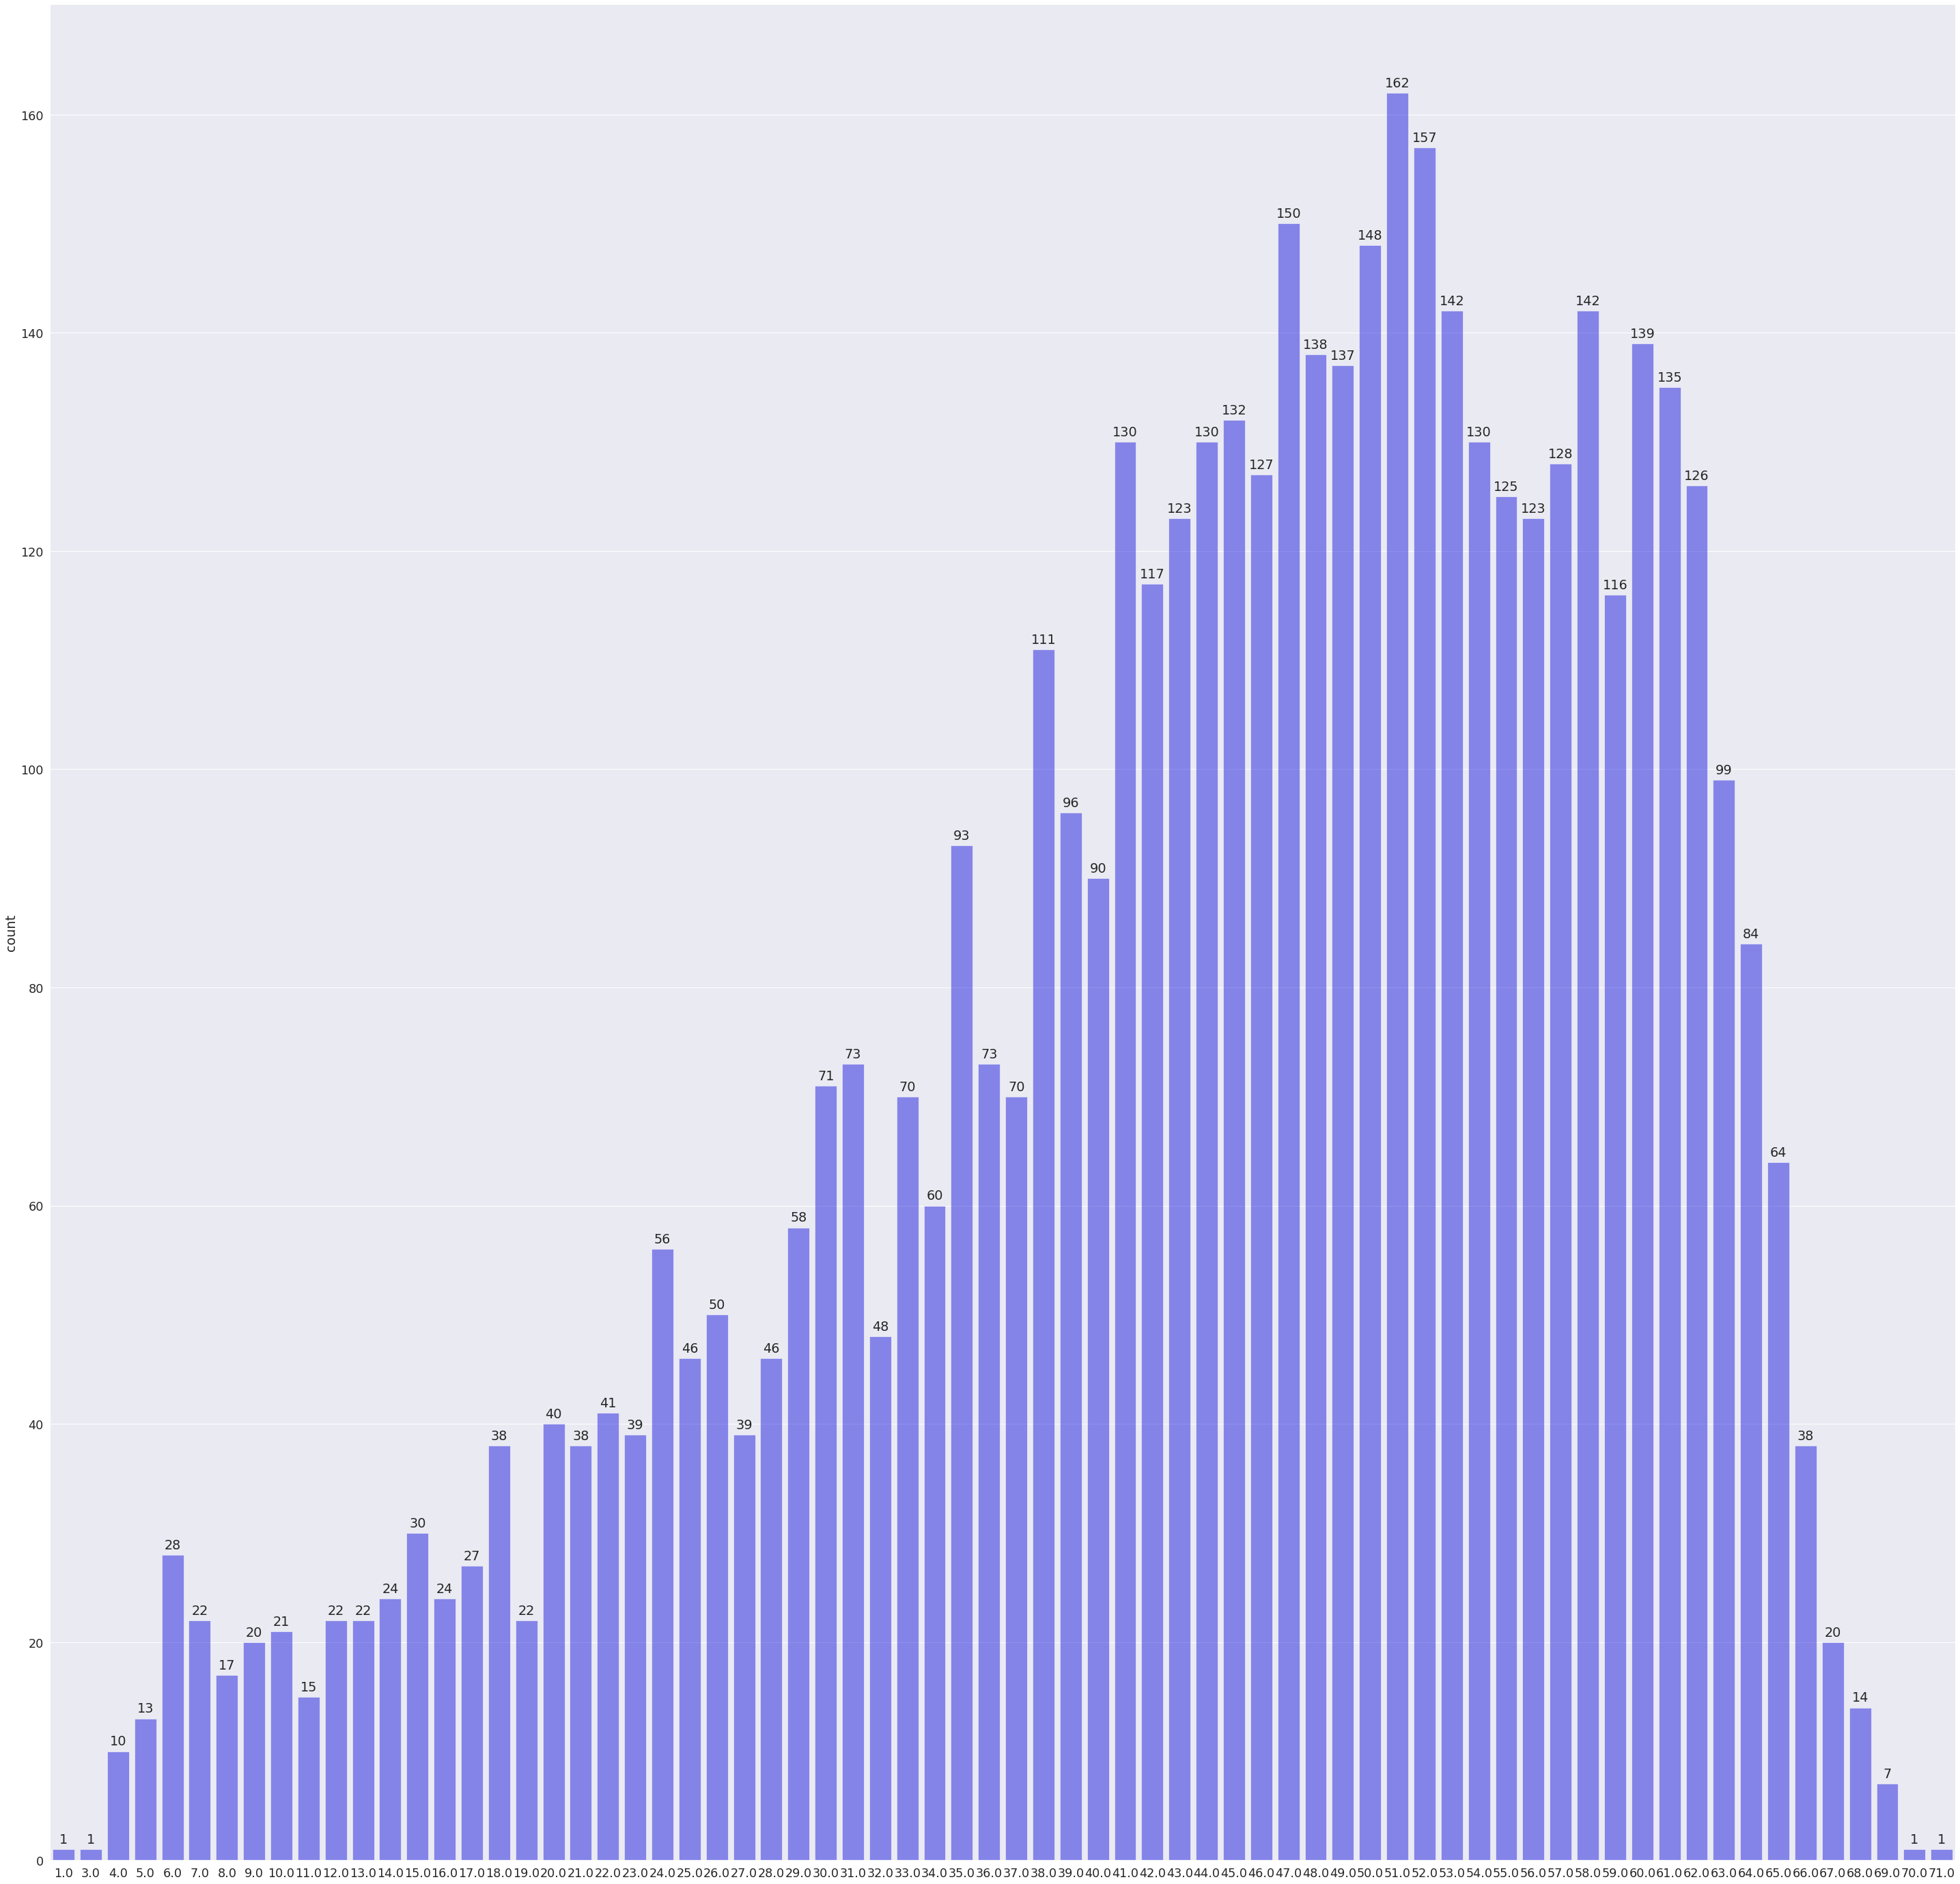

In [13]:
distancemap=distance_map(df, "blosum 100 first peps","Blossom",pep_number=100,random_sampling=False,save_fig=False,xlabel=None,ylabel=None)
distance_distribution(distancemap,"Blosum")